Wine Quality

* 1 - Good
* 0 - Evil

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, probplot
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report

In [2]:
df_train = pd.read_csv('wineQuality_train.data')
df_valid = pd.read_csv('wineQuality_val.data')

# 1 - Visualization

In [3]:
print(df_train.dtypes)

fixed.acidity           float64
volatile.acidity        float64
citric.acid             float64
residual.sugar          float64
chlorides               float64
free.sulfur.dioxide     float64
total.sulfur.dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


In [4]:
df_train.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
0,7.1,0.33,0.30,3.3,0.034,30.0,102.0,0.9912,3.08,0.31,12.3,1
1,6.0,0.39,0.17,12.0,0.046,65.0,246.0,0.9976,3.15,0.38,9.0,0
2,7.9,0.18,0.49,5.2,0.051,36.0,157.0,0.9953,3.18,0.48,10.6,0
3,6.2,0.28,0.51,7.9,0.056,49.0,206.0,0.9956,3.18,0.52,9.4,0
4,7.0,0.50,0.25,2.0,0.070,3.0,22.0,0.9963,3.25,0.63,9.2,0


In [5]:
# About 1/3 For validation...

print('Train Size: ', df_train.size)
print('Validation Size: ', df_valid.size)
print('{:.2f}%'.format((df_valid.size / df_train.size) * 100))

Train Size:  46776
Validation Size:  15588
33.32%


In [6]:
# Boundaries

for col in df_train.columns:
    print(f'x ∈ {col:>20} | {df_train[col].min():>6.2f} <= x <= {df_train[col].max():>6.2f}')

x ∈        fixed.acidity |   3.80 <= x <=  15.90
x ∈     volatile.acidity |   0.08 <= x <=   1.58
x ∈          citric.acid |   0.00 <= x <=   1.66
x ∈       residual.sugar |   0.60 <= x <=  65.80
x ∈            chlorides |   0.01 <= x <=   0.61
x ∈  free.sulfur.dioxide |   1.00 <= x <= 146.50
x ∈ total.sulfur.dioxide |   6.00 <= x <= 366.50
x ∈              density |   0.99 <= x <=   1.04
x ∈                   pH |   2.74 <= x <=   4.01
x ∈            sulphates |   0.23 <= x <=   2.00
x ∈              alcohol |   8.00 <= x <=  14.90
x ∈              quality |   0.00 <= x <=   1.00


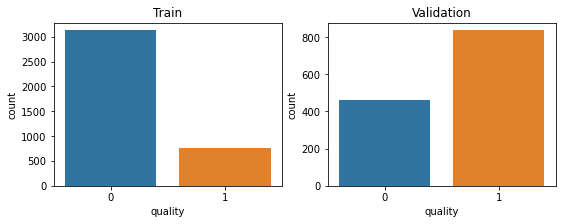

In [7]:
# I sense a disturbance in the force...

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.title('Train')
sns.countplot(df_train['quality'])
plt.subplot(122)
plt.title('Validation')
sns.countplot(df_valid['quality'])
plt.show()

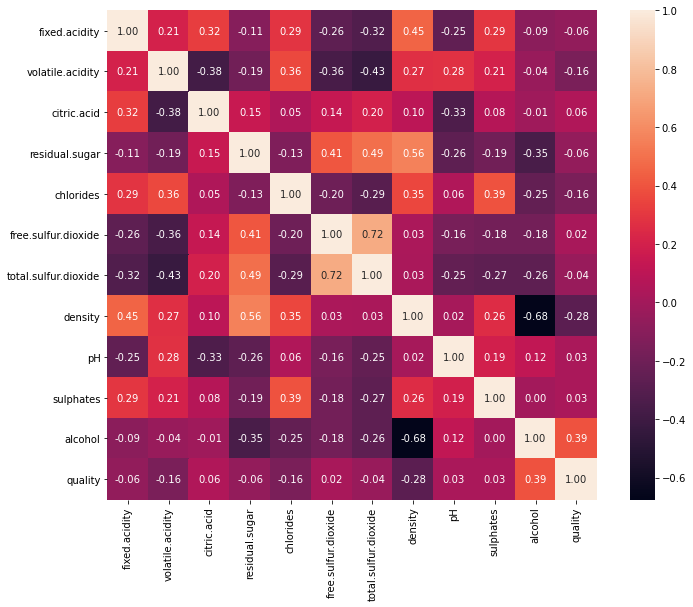

In [8]:
# Correlation matrix

corr_mat = df_train.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, square=True, cbar=True, annot=True, fmt='.2f')

# 2 - Normalization

In [9]:
# Drop all columns with negative correlation
out_columns = ['fixed.acidity', 'volatile.acidity', 'residual.sugar', 'chlorides', 'density']

df_train.drop(out_columns, inplace=True, axis=1)
df_valid.drop(out_columns, inplace=True, axis=1)

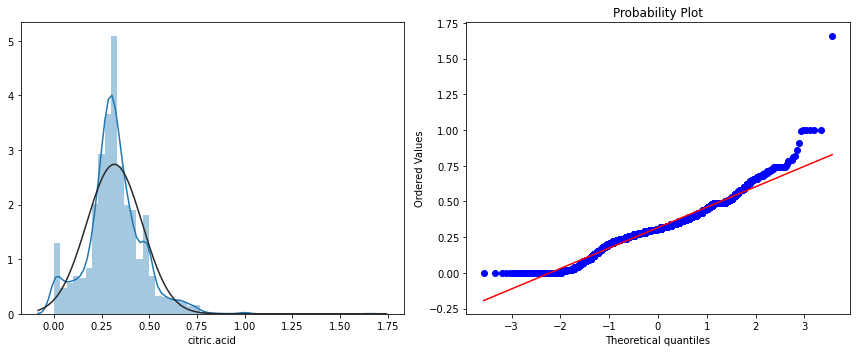

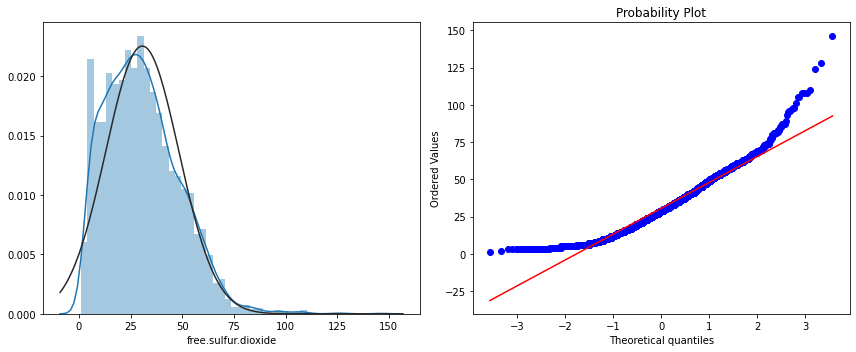

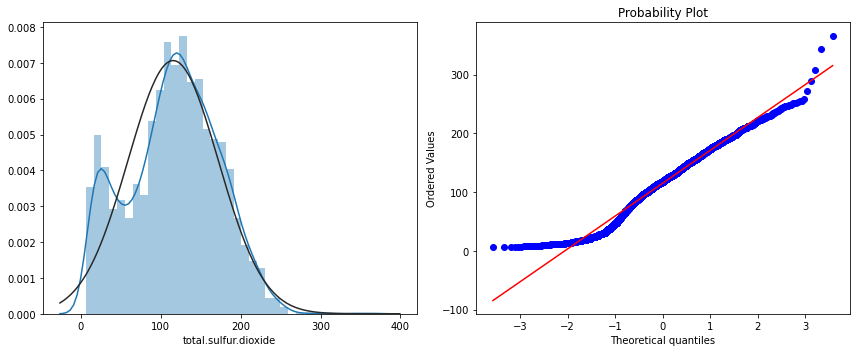

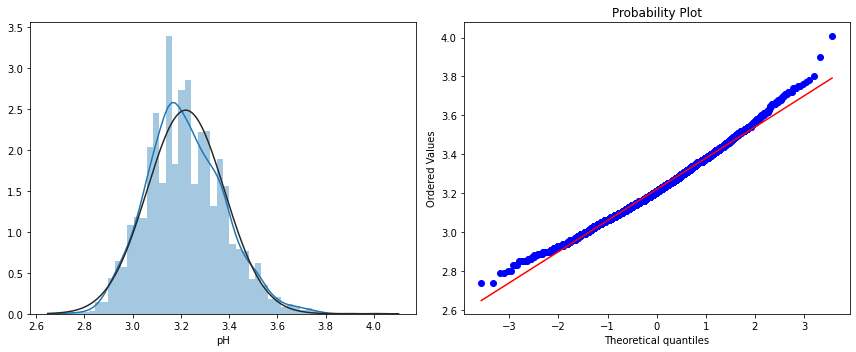

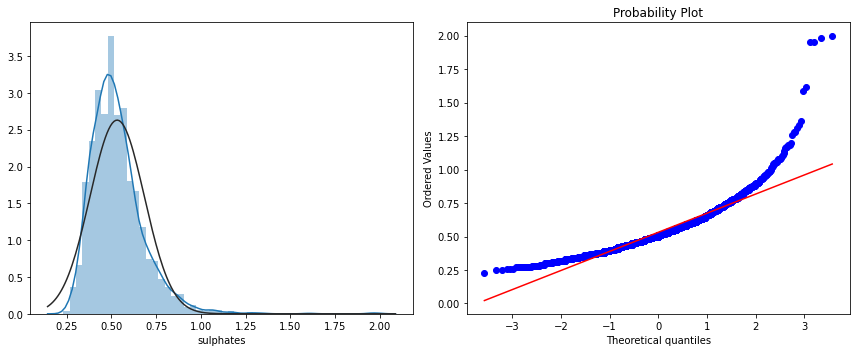

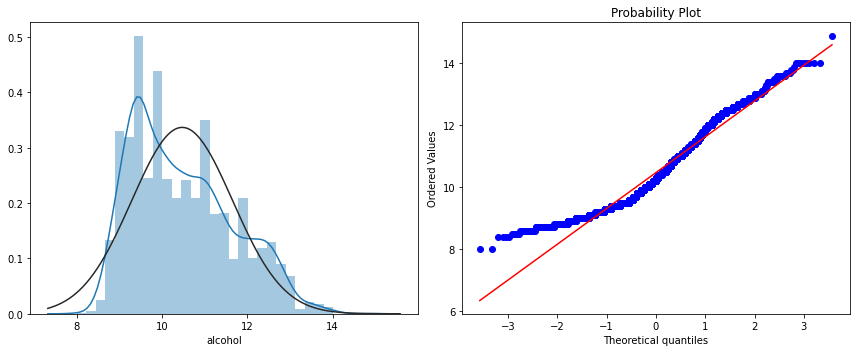

In [10]:
# What is the distribution of each feature

for col in df_train.columns:
    if col == 'quality':
        continue
    plt.figure(figsize=(12.0, 5.0))
    plt.subplot(121)
    _ = sns.distplot(df_train[col], fit=norm)
    plt.subplot(122)
    _ = probplot(df_train[col], plot=plt)
    plt.tight_layout()

In [11]:
# Missing Data (nothing! :D)

total = df_train.isnull().sum().sort_values()
print(total)

citric.acid             0
free.sulfur.dioxide     0
total.sulfur.dioxide    0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [12]:
# Having all variables as float64
df_train['quality'] = df_train['quality'].astype(float)
df_valid['quality'] = df_valid['quality'].astype(float)

# Splitting X and Y
x_train = df_train.loc[:, df_train.columns != 'quality'].to_numpy()
y_train = df_train['quality'].to_numpy()

x_valid = df_valid.loc[:, df_valid.columns != 'quality'].to_numpy()
y_valid = df_valid['quality'].to_numpy()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(3898, 6) (3898,)
(1299, 6) (1299,)


In [13]:
# Normalization using MinMaxScaler
# All values are now between 0 - 1

x_train = MinMaxScaler().fit_transform(x_train)
x_valid = MinMaxScaler().fit_transform(x_valid)

x_train[:5]

array([[0.18072289, 0.19931271, 0.26629681, 0.26771654, 0.04519774,
        0.62318841],
       [0.10240964, 0.43986254, 0.66574202, 0.32283465, 0.08474576,
        0.14492754],
       [0.29518072, 0.24054983, 0.41886269, 0.34645669, 0.14124294,
        0.37681159],
       [0.30722892, 0.32989691, 0.55478502, 0.34645669, 0.16384181,
        0.20289855],
       [0.15060241, 0.0137457 , 0.0443828 , 0.4015748 , 0.2259887 ,
        0.17391304]])

# 3 - Training Model

In [14]:
model = SVC(kernel='rbf', C=10)
model.fit(x_train, y_train)

SVC(C=10)

# 4 - Classification

In [15]:
y_pred = model.predict(x_valid)

acc = accuracy_score(y_valid, y_pred)
print("Accuracy: ", acc)

Accuracy:  0.4765204003079292


In [16]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.40      0.99      0.57       463
         1.0       0.96      0.19      0.32       836

    accuracy                           0.48      1299
   macro avg       0.68      0.59      0.45      1299
weighted avg       0.76      0.48      0.41      1299

